In [104]:
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib as mpl
from matplotlib import pyplot as plt

from scipy.stats import zscore

from collections import defaultdict, Counter

import re

import scipy.spatial as sp
import scipy.cluster.hierarchy as hc

from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

# Summary

This notebook describes how to roughly reproduce the analysis leading up to Figure 3.

In [426]:
hs_muts = pd.read_hdf("../data/hs_muts.h5",key="hs_muts")
damaging_muts = pd.read_hdf("../data/damaging_muts.h5",key="damaging_muts")
fusions = pd.read_csv("../data/CCLE_Fusions_20181130.txt",sep="\t")

chromatin_profiling = pd.read_hdf("../data/CCLE_GlobalChromatinProfiling_20181130.hdf",key="chromatin_profiling")
mutation_calls = pd.read_hdf("../data/depmap_19Q1_mutation_calls.h5",key="mutation_calls")

chromatin_profiling = chromatin_profiling.dropna(axis=1,thresh=875)

In [617]:
nsd2_fusions = fusions[(fusions["LeftGene"]=="WHSC1")|(fusions["RightGene"]=="WHSC1")]
nsd2_fused = set(nsd2_fusions["BroadID"])

In [428]:
hs_muts = hs_muts.loc[chromatin_align.index]

CREBBP TAZ2 (CH3)-specific truncating mutations were annotated as the truncating mutations in CREBBP occurring between amino acids 1745 and 1846 (affecting the TAZ2 (CH3) domain but not the ZZ domain). Similarly, for EP300 TAZ2 (CH3)-specific truncating mutations, we included any truncating mutation in EP300 occurring between amino acids 1708 and 1809 (Fig. 3, Extended Data Fig. 7a).

In [429]:
crebbp = mutation_calls[mutation_calls["Hugo_Symbol"]=="CREBBP"]
crebbp = crebbp[crebbp["Variant_annotation"]=="damaging"]
crebbp = crebbp.dropna(subset=["Protein_Change"])

crebbp["codon_n"] = crebbp["Protein_Change"].apply(lambda x: int(re.search("[0-9]+",str(x))[0]))
crebbp = crebbp[(crebbp["codon_n"]>=1745)&(crebbp["codon_n"]<=1846)]
crebbp = set(crebbp["DepMap_ID"])

In [430]:
ep300 = mutation_calls[mutation_calls["Hugo_Symbol"]=="EP300"]
ep300 = ep300[ep300["Variant_annotation"]=="damaging"]
ep300 = ep300.dropna(subset=["Protein_Change"])

ep300["codon_n"] = ep300["Protein_Change"].apply(lambda x: int(re.search("[0-9]+",str(x))[0]))
ep300 = ep300[(ep300["codon_n"]>=1708)&(ep300["codon_n"]<=1809)]
ep300 = set(ep300["DepMap_ID"])

In [620]:
mut_df = pd.DataFrame(index=chromatin_profiling.index)

mut_df["CREBBP"] = mut_df.index.map(lambda x: x in crebbp)
mut_df["EP300"] = mut_df.index.map(lambda x: x in ep300)
mut_df["EZH2"] = hs_muts["EZH2"]
mut_df["NSD2_fused"] = mut_df.index.map(lambda x: x in nsd2_fused)

mut_df = mut_df.astype(int)

In [621]:
chromatin_align = chromatin_profiling.fillna(chromatin_profiling.mean())

chromatin_align = chromatin_align.apply(zscore)

In [622]:
n_clusters = 24

cell_line_linkage = hc.linkage(chromatin_align, method='ward')

clusters = hc.fcluster(cell_line_linkage, n_clusters, "maxclust")
clusters = pd.Series(clusters, index=chromatin_align.index)

cluster_colors = get_colors(clusters, "tab20")

In [623]:
cluster_splits = [chromatin_align.loc[clusters==x] for x in range(1,n_clusters+1)]
cluster_muts = [mut_df.loc[clusters==x] for x in range(1,n_clusters+1)]

lengths = [len(x) for x in cluster_splits]

total_lines = sum(lengths)

cumulative_lengths = [0]+list(np.cumsum(lengths))

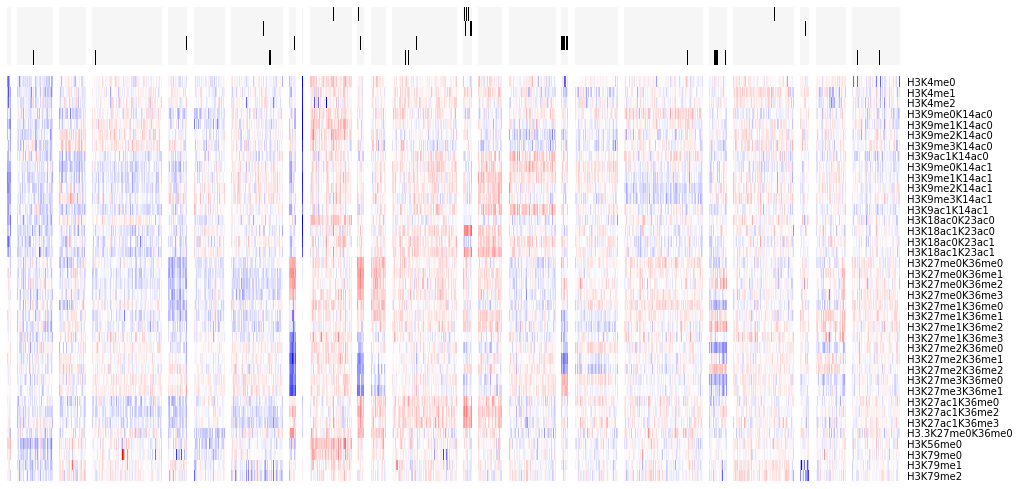

In [626]:
fig = plt.figure(figsize=(16,10))

spacing = 8

gs = mpl.gridspec.GridSpec(8,total_lines+spacing*(n_clusters-1))

for cluster_idx, cluster in enumerate(cluster_splits):
    
    indent = spacing*cluster_idx
    
    ax = fig.add_subplot(gs[2:,cumulative_lengths[cluster_idx]+indent:cumulative_lengths[cluster_idx+1]+indent])
            
    ax.imshow(cluster.T,aspect="auto",vmin=-8,vmax=8,cmap="bwr")
    
    plt.box(False)

    if cluster_idx == n_clusters-1:
        ax.set_xticklabels([])
        ax.set_yticks(list(range(len(chromatin_align.columns))))
        ax.set_yticklabels(chromatin_align.columns)
    
        ax.xaxis.set_ticks_position('none') 
        
        ax.yaxis.tick_right()
        ax.yaxis.set_ticks_position('none') 
        
    else:
        plt.axis('off')

    ax = fig.add_subplot(gs[1,cumulative_lengths[cluster_idx]+indent:cumulative_lengths[cluster_idx+1]+indent])
    
    ax.imshow(cluster_muts[cluster_idx].T, aspect="auto",cmap=mpl.colors.ListedColormap(["#f6f6f6","black"]))
    
    if cluster_idx == n_clusters-1:
        ax.set_xticklabels([])
        ax.set_yticks(list(range(4)))
        ax.set_yticklabels()
    
        ax.xaxis.set_ticks_position('none') 
        
        ax.yaxis.tick_right()
        ax.yaxis.set_ticks_position('none') 
        
    else:
        plt.axis('off')

    

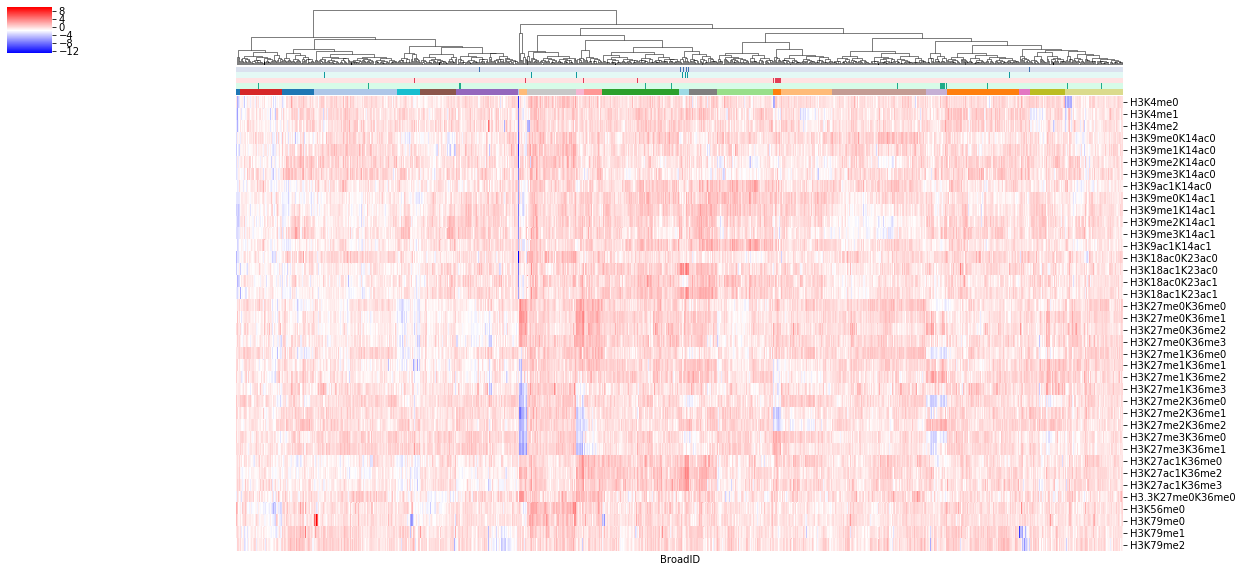

In [488]:
sns.clustermap(chromatin_align.T,
               method="ward",
               metric="euclidean",
               cmap="bwr",
               col_colors=[ep300_colors, crebbp_colors,
                           ezh2_colors, nsd2_colors, cluster_colors],
               figsize=(20, 10),
               xticklabels=False,
               row_cluster=False
               )